In [3]:
import os
import pymysql
import dotenv
from dotenv import load_dotenv
load_dotenv()

HOST = os.getenv('HOST')
USER = os.getenv('MYSQL_USER')
PASSWORD = os.getenv('MYSQL_ROOT_PASSWORD')
DB = os.getenv('MYSQL_DATABASE')

connection = pymysql.connect(host=HOST, 
                      user = USER,
                     password = PASSWORD,
                     db = DB)

cursor = connection.cursor()

* ## Quantos usuários únicos não jogaram após o dia 03/02/2020?
> A análise de jogos por usuário será feita a partir de updated_at (última atualização do registro), na tabela matchmaking_stats_summary

>OBS: updated_at e created_at possuem sempre a mesma data neste banco de dados
>Como o número de usuários que jogaram é diferente do número de usuários distintos, sei que um mesmo usuário jogou várias partidas.

In [2]:
#Retrieving the total user number:
total_registros = cursor.execute("SELECT player_id FROM matchmaking_stats_summary")
total = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary")
(total_registros, total)
#27 usuers has played more than one single date 

(2057, 2030)

In [3]:
#"%Y/%m/%d"
#Retrieving the number of players who played after this date 03/02/2020
strong_players = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at >= '2020-02-03'")
strong_players

1304

In [5]:
#Retrieving the number of player who haven't played
weak_players = total - strong_players
weak_players

726

* ## Quantos usuários únicos jogaram em fevereiro após o dia 06/02/2020?
> Usando o mesmo raciocínio do exercício anterior 

In [8]:
#Retrieving the total user number:
total = cursor.execute("SELECT distinct player_id FROM matchmaking_stats_summary")
total

2030

In [12]:
#Retrieving the number of users who played after the date 
faithful_players = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at > '2020-02-06 23:59:59'")
faithful_players

0

In [14]:
#or
faithful_players = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at >= '2020-02-07'")
faithful_players

0

* ## Em qual dia mais jogadores deixaram de jogar no mês de fevereiro?
>No caso, vou usar a mesma tabela, e fazer as operações passo a passo:

In [16]:
#Retrieving the number of active players during the month of February (players who updated their stats)
feb_players = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-01 00:00:00' AND '2020-02-29 23:59:59'")
feb_players
#every player have done some update in their stats during this month

2030

* ### Checking by day:

In [19]:
day1 = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-01 00:00:00' AND '2020-02-01 23:59:59'")
day1

326

In [20]:
day2 = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-02 00:00:00' AND '2020-02-02 23:59:59'")
day2

408

In [21]:
day3 = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-03 00:00:00' and '2020-02-03 23:59:59'")
day3

313

In [22]:
day4 = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-04 00:00:00' and '2020-02-04 23:59:59'")
day4

330

In [23]:
dia5 = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-05 00:00:00' and '2020-02-05 23:59:59'")
dia5

338

In [24]:
dia6 = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-06 00:00:00' and '2020-02-06 23:59:59'")
dia6

330

 >## In the above case we can see that all players have played in February. We can notice that 03/02/2020 was the day where less players have played. 
>## We must be careful looking these numbers, because the variables dayN refers to the number of active single players in that day, but in this analyse we can't say who are the players. Thus, the sum of number of players of variables dayN are going to be higher than the feb_players variable (number of total single player in the February mounth). 
>## We can take a look in the intersection between these variables:

In [4]:
cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-06 00:00:00' and '2020-02-06 23:59:59'")
a = cursor.fetchall()
cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary WHERE updated_at BETWEEN '2020-02-06 00:00:00' and '2020-02-06 23:59:59'")
b = cursor.fetchall()

In [6]:
intersec = set(a).intersection(set(b))
len(intersec)

330

In [12]:
#10 players ids
list(intersec)[0:10]

[(1269653,),
 (802646,),
 (576674,),
 (786888,),
 (1268835,),
 (27390,),
 (858828,),
 (1234254,),
 (471706,),
 (345015,)]

## Observations regarding the tables

* ### The number of players:
>The number of players is different between the tables. Therefore is hard to do the correlation between these tables, because not all the tables contain every player.

In [4]:
players = cursor.execute("SELECT DISTINCT player_id FROM players")
players_matchmaking = cursor.execute("SELECT DISTINCT player_id FROM matchmaking_stats_summary")
players_monthly = cursor.execute("SELECT DISTINCT player_id FROM player_monthly_stats")
players, players_matchmaking, players_monthly

(3645, 2030, 3700)

* ### created_at == updated_at:
>Every created_at date is equal updated_at date.

In [13]:
query1 = "SELECT created_at FROM matchmaking_stats_summary WHERE created_at=updated_at;"
query2 = "SELECT created_at FROM matchmaking_stats_summary WHERE created_at!=updated_at;"
cursor.execute(query1), cursor.execute(query2)

(2057, 0)

# Correlation Using Pandas

In [1]:
import pandas as pd
match = pd.read_csv('csv/matchmaking_stats.csv')

/home/visus/.pyenv/versions/3.7.0/lib/python3.7/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
#Removing the unnecessaries columns
my_df = match.drop(columns=['player_id', 'created_at', 'updated_at'])

* ## Aplying the Pearson Correlation Method:
>Correlation between sets of data is a measure of how well they are related. The most common measure of correlation in stats is the Pearson Correlation. The full name is the Pearson Product Moment Correlation (PPMC). It shows the linear relationship between two sets of data. In simple terms, it answers the question, Can I draw a line graph to represent the data?
    * #### Source: https://www.statisticshowto.com/probability-and-statistics/correlation-coefficient-formula/

In [3]:
#Checking if is there a player with no matches played
len(my_df['matches_played']), my_df[ my_df['matches_played'] == 0]
#No, there isn't

(2057,
 Empty DataFrame
 Columns: [matches_played, total_wins, total_loss, mm_points, kills, death, assist, hs]
 Index: [])

In [4]:
my_df.corr(method ='pearson')

,matches_played,total_wins,total_loss,mm_points,kills,death,assist,hs
matches_played,1.000000,0.887964,0.878356,0.689930,0.974546,0.984908,0.949598,0.914814
total_wins,0.887964,1.000000,0.560330,0.944465,0.906658,0.855386,0.884865,0.881565
total_loss,0.878356,0.560330,1.000000,0.261150,0.812837,0.885040,0.790564,0.731682
mm_points,0.689930,0.944465,0.261150,1.000000,0.740193,0.651729,0.723895,0.743512
kills,0.974546,0.906658,0.812837,0.740193,1.000000,0.973337,0.956963,0.954986
death,0.984908,0.855386,0.885040,0.651729,0.973337,1.000000,0.953071,0.910926
assist,0.949598,0.884865,0.790564,0.723895,0.956963,0.953071,1.000000,0.901647
hs,0.914814,0.881565,0.731682,0.743512,0.954986,0.910926,0.901647,1.000000


* ## Showing in a Heatmap:

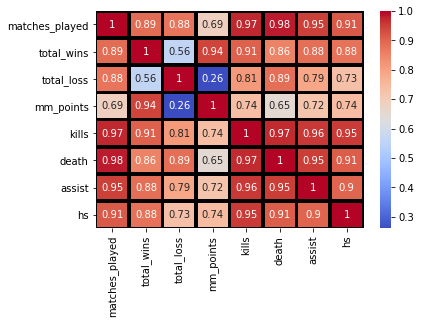

In [5]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
heatmap_chart = sns.heatmap(my_df.corr(method ='pearson'), annot = True, fmt='.2g', 
            cmap= 'coolwarm', linewidths=2.5, linecolor='black')
heatmap_chart

__Table Caption:__
* n > 0.9: There is a very strong correlation;
* n = 1: The perfect correlation;
* 0.7 > n > 0.9: There is a strong correlation;
* 0.5 > n > 0.7: There is a moderate correlation;
* There isn't any negative correlation.


In [7]:
#exporting this image to images/
figure = heatmap_chart.get_figure()    
figure.savefig('images/heatmap_chart_matchmakingsummary.png', dpi=400)

>In the table above we can see a strong correlation between matches_played and every other rows. As expected.

>Looking for these image we can notice that the releated players are good players, because the correlation between total wins and matches played is higher than the correlation between total loss and matches played (even if small
). But mainly because there is a high correlation between matches played and hs, and it is important because hs is difficult to be done (at least for me). Another stuff can be noticed looking at this image is that is expected that every single player execute a kill at each match, because the correlation between these variables is near than 1.

>There is not a inverse correlation between the variables, it could means that these players know how to player like a team, not a single player. Total loss and mm points are inversely proportional variables, but the correlation show that a loss give a small positive score, not a negative one. 

In [23]:
monthly = pd.read_csv('csv/monthly_stats.csv')

In [24]:
#Checking if is there a player with total_played = 0
len(monthly['total_played']), monthly[ monthly['total_played'] == 0]
#No, there isn't

(3700,
 Empty DataFrame
 Columns: [player_id, game_mode, ref_date, total_played, kills, deaths, assists, wins, loss, headshots]
 Index: [])

In [50]:
my_df2 = monthly.drop(columns=['player_id', 'game_mode', 'ref_date'])
my_df2.corr(method ='pearson')

,total_played,kills,deaths,assists,wins,loss,headshots
total_played,1.000000,0.980313,0.991676,0.977086,0.962017,0.956470,0.943267
kills,0.980313,1.000000,0.981154,0.973452,0.965331,0.931750,0.973025
deaths,0.991676,0.981154,1.000000,0.981392,0.957663,0.967152,0.945501
assists,0.977086,0.973452,0.981392,1.000000,0.957183,0.933927,0.939418
wins,0.962017,0.965331,0.957663,0.957183,1.000000,0.876682,0.936704
loss,0.956470,0.931750,0.967152,0.933927,0.876682,1.000000,0.886583
headshots,0.943267,0.973025,0.945501,0.939418,0.936704,0.886583,1.000000


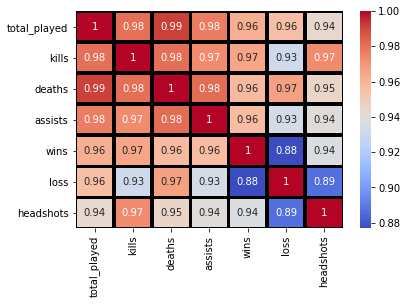

In [51]:
heatmap_chart_monthly = sns.heatmap(my_df2.corr(method ='pearson'), annot = True, fmt='.2g', 
            cmap= 'coolwarm', linewidths=2.5, linecolor='black')
heatmap_chart_monthly

__Table Caption:__
* n > 0.9: There is a very strong correlation;
* n = 1: The perfect correlation;
* 0.7 > n > 0.9: There is a strong correlation;
* There isn't any negative correlation.

In [52]:
#exporting this image to images/
figure2 = heatmap_chart_monthly.get_figure()    
figure2.savefig('images/heatmap_chart_monthly.png', dpi=400)

>The same interpretation can be done analysing this image. In this image is easier to see the strong relation between wins and headshots, we can conclude that there is a big number of wins with headshot, therefore these are a very good players. 